# Nadaraja-Votson regresija

**Nadaraja-Votson** regresija je regresija koja omogućava modelovanje nelinearnih zavisnosti između ulaznih i izlaznih veličina. Osnovna ideja ovog tipa regresije je da se novoj instanci pridruži vrednost koja je "slična" vrednostima njenih "okolnih" instanci. U opštem slučaju, sve instance se mogu smatrati okolnim instancama. One instance koje su bliže polaznoj instanci imaju veći uticaj na vrednost njene ciljne promenljive, dok one koje su dalje od nje imaju manji uticaj. Stoga je vrednost ciljne promenljive za novu instancu neka vrsta težinskog proseka $y = \frac{1}{N}\sum_{i=1}^{i=N}{\omega_i  y_i}$ gde vrednosti koeficijenata $\omega_i$ zavise od korišćene funkcije rastojanja tj. sličnosti između instanci. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(10)

Gausov kernel aproksimira rastojanje imeđu instanci $x_1$ i $x_2$ funkcijom $$K_{\sigma}(x_1, x_2) = \frac{1}{\sqrt{2\pi\sigma^2}} e ^{-\frac{(x_1-x_2)^2}{2\sigma^2}}$$

Parametar $\sigma^2$ se zove širina (engl. bandwidth) kernela. 


Dešinišimo funkciju koja računa vrednost Gausovog kernela.

In [3]:
def kernel(x1, x2, bandwidth):
    e = np.exp(-0.5*((x1-x2)**2) / bandwidth**2)
    return e / np.sqrt(2*np.pi*bandwidth**2)

Generišimo skup 100 tačaka sa vrednostima iz uniformne raspodele [-1, 1).

In [4]:
N = 100
x = np.random.uniform(-1, 1, N)

Slika ilustruje kako se kernel koristi za merenje sličnosti između instanci. Kako se porede instance (u opštem slučaju vektori) $x$ i $z$, kernel ima veće vrednosti oko $0$ sa obzirom da tu vrednost vektora $x$ biva vrlo slična vrednostima vektora $z$ (koji je svuda nula).

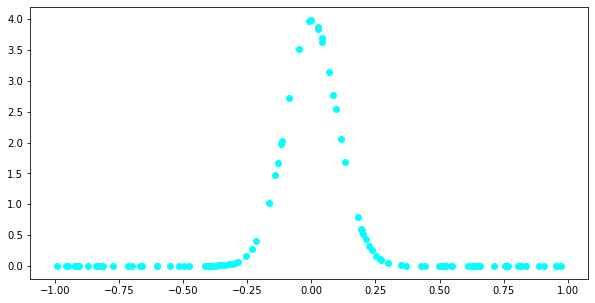

In [5]:
z = np.zeros(N)
plt.figure(figsize=(10,5))
plt.scatter(x, kernel(z, x, 0.1), color='aqua')

Generišimo i skup vrednosti $y$ tako da između $x$ i $y$ važi nelinearna veza.

In [6]:
y = (x+1)**2 + np.random.randn(N)

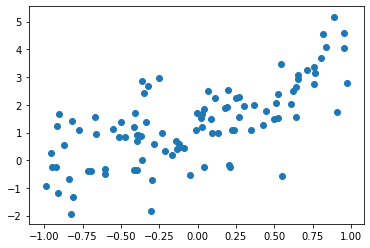

In [7]:
plt.scatter(x, y)

Dalje želimo da aproksimiramo modelom Nadaraja-Votoson regresije polaznu zavisnost.

Model Nadaraja-Votson regresije određen je jednačinom
$$
y_{new}=\frac{\sum_{i=1}^{N} K_\sigma (x_{new}, x_i) \cdot y_i}{\sum_{j=1}^{N} K_\sigma(x_{new},  x_j)}
$$

Funkcija `estimator` izračunava vrednost ciljne promenljive za novu instancu $n_{new}$.

In [8]:
def estimator(x_new, x, y, bandwidth):
    kernel_value = kernel(x, x_new, bandwidth)
    return np.sum(kernel_value * y) / np.sum(kernel_value)

U ovom primeru ćemo peške implementirati i funkcije za podelu podataka na skup za treniranje i skup za testiranje.

Funkcija `randomize` nasumično meša elemente skupova `x` i `y` ali tako da vrednosti ostanu uparene. 

In [9]:
def randomize(x, y):
    indexes = np.arange(x.size)
    np.random.shuffle(indexes)
    return x[indexes], y[indexes]

Funkcija `split_datasets` deli skupove `x` i `y` u zadatoj razmeri. Redosled skupova koji se vraćaju je nešto drugačije od korišćene `train_test_split` metode biblioteke `scikit-learn`.

In [10]:
def split_datasets(x, y, ratio=2/3):
    
    x, y = randomize(x, y)
    
    N = x.size
    
    # prvi deo skupa cemo zvati train_validation skup
    x_train_validation = x[:int(N*ratio)]
    y_train_validation = y[:int(N*ratio)]
    
    # drugi deo skupa cemo zvati test skup
    x_test = x[int(N*ratio):]
    y_test = y[int(N*ratio):]
    
    return x_train_validation, y_train_validation, x_test, y_test

Funkcija `mse` računa srednjekvadratnu grešku na osnovu prosleđenih reziduala.

In [11]:
def mse(residuals):
    residuals = np.array(residuals)
    return np.mean(residuals**2)

Delimo podatke napisanom funkcijom na skup za treniranje i validaciju i skup za testiranje. 

In [12]:
x_train_validation, y_train_validation, x_test, y_test = split_datasets(x, y)

In [13]:
print('Broj instanci skupa za treniranje i validaciju: ', x_train_validation.size)
print('Broj instanci skupa za testiranje: ', x_test.size)

Broj instanci skupa za treniranje i validaciju:  66
Broj instanci skupa za testiranje:  34


Dalje želimo da odredimo optimalnu vrednost širine Gausovog kernela. Ovaj postupak ćemo izvesti korišćenjem takozvane `live-one-out` ocene koja je podesna za manje skupove instanci. 
<img src='assets/leave_one_out_cross-validation.png'>

Naime, iz skupa za treniranje i validaciju biraćemo jednu po jednu instancu za validacioni skup, a na preostalim instancama ćemo trenirati model. To bi značilo da ćemo, ako imamo 66 instanci u skupu za treniranje i validaciju, postupak ponovi 66 puta. U prvoj koraku ćemo iskoristiti prvu instancu za validaciju, a preostale za treniranje modela, u drugom koraku ćemo iskoristiti drugu instancu za validaciju, a preostale za treniranje, i tako redom. 

Ovaj pristup nam je zgodan kada raspolažemo malim skupom podataka jer možemo da iskoristimo maksimalan broj instanci za treniranje i propisno obavimo ocenu na skupu za validaciju. 

Niz mogućih vrednosti širine kernela:

In [14]:
bandwidths = np.array([0.01, 0.1, 0.5, 1, 5, 10, 100])

In [15]:
# niz sa greškama modela za različite izbore širine kernela
errors = []

# za svaku vrednost sirine kernela
for bandwidth in bandwidths:
    
    # postavljamo niz gresaka leave-one-out validacije na nula
    # duzina ovog niza odgovara broju instanci u skup
    leave_one_out_errors = np.zeros(x_train_validation.size)
    
    # svaku instancu x_train_validation[i] 
    for i in range(0, x_train_validation.size):
        
        # prvo izbacujemo iz skupa podataka kako bismo dobili trening skupove
        # x_fit i y_fit su skupovi instanci BEZ i-te instance
        x_fit = np.delete(x_train_validation, i)
        y_fit = np.delete(y_train_validation, i)
        
        # zatim, predvidjamo njenu vrednost na osnovu skupova x_fit, y_fit
        y_predicted = estimator(x_train_validation[i], x_fit, y_fit, bandwidth)
        
        # zatim odredjujemo gresku koju smo napravili i upisujemo je u vektor reziduala
        error = y_train_validation[i] - y_predicted
        leave_one_out_errors[i] = error
        
    # kada zavrsimo sa leave-one-out ocenom, racunamo srednjekvadratnu gresku i upisujemo je u listu sa greskama    
    error = mse(leave_one_out_errors)
    
    errors.append(error)

In [16]:
errors

[1.6110351716883593,
 1.030223469532878,
 1.1550712143330568,
 1.6107074891400457,
 2.059605746381693,
 2.078721917304861,
 2.0851095594623366]

In [17]:
# Biramo širinu kernela za koju smo dobili najmanju grešku
best_bandwidth = bandwidths[np.argmin(errors)]
best_bandwidth

0.1

Vršimo testiranje na test skupu za odabranu širinu kernela. Ovaj postupak ćemo, takođe, proći peške. 

In [18]:
y_predictions = []
test_errors = []

# Prolazimo kroz test skup instancu po instancu
for x_new, y_new in zip(x_test, y_test):
    # vrsimo predikciju za instancu x_new
    y_predicted = estimator(x_new, x_train_validation, y_train_validation, best_bandwidth)
    
    # upisujemo predikciju u niz sa predikcijama
    y_predictions.append(y_predicted)
    
    # i belezimo gresku, odnosno, pamtimo reziduale
    error = y_predicted - y_new
    
    test_errors.append(error)

In [19]:
# računamo srednjekvadratnu grešku na test skupu
test_error = mse(test_errors)
test_error

1.094407857301028

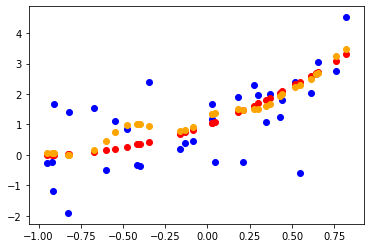

In [20]:
# Iscrtavamo instance iz skupa za testiranje
plt.scatter(x_test, y_test, color='blue')

# Iscrtavamo tacke ciljne funkcije
plt.scatter(x_test, (x_test + 1)**2, color='red')

# Iscrtavamo predikcije za instance iz skupa za testiranje
plt.scatter(x_test, y_predictions, color='orange')